In [17]:
import numpy as np
import pandas as pd

from src.data_preprocessing import clean_text, transform_tfidf
from src.model import gradient_descent, predict, pred_to_accuracy, get_best_vals
from src.viz import graph_log_loss

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Read data
train_raw = pd.read_csv("data/train.csv")
test_raw = pd.read_csv("data/test.csv")
y_test_raw = pd.read_csv("data/submit.csv")

In [20]:
# Implement data cleaning and text preprocessing
test_raw = test_raw.join(y_test_raw["label"])
train_clean = clean_text(train_raw)
test_clean = clean_text(test_raw)
y_train = train_clean["label"].to_numpy()
y_test = test_clean["label"].to_numpy()

In [4]:
# tf-idf transformation
X_train, X_test, words = transform_tfidf(train_clean["text"], test_clean["text"])

X_train = X_train.todense()
X_test = X_test.todense()
X_train.shape

(18285, 16770)

In [5]:
n, p = X_train.shape

# Shuffle training data
indices = np.random.permutation(n)
X_train = X_train[indices,:]
y_train = y_train[indices]

# Set training parameters
folds = 3
n_alphas = 10
lambdas = [0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001]

In [6]:
# Get average train log loss for each lambda and alpha
avg_loss_by_penalty = np.empty((n_alphas + 1,len(lambdas)))
for i, lambda_ in enumerate(lambdas):
    log_loss = np.empty((n_alphas+ 1,folds))
    buckets = list(range(0, n + 1, n//folds))
    
    for k in range(folds):
        val1 = buckets[k]
        val2 = buckets[k+1]

        X_val_bucket = X_train[val1:val2,:]
        X_train_buckets = np.delete(X_train, np.s_[val1:val2], axis=0)

        y_val = y_train[val1:val2]
        y_train2 = np.delete(y_train, np.s_[val1:val2], axis=0)

        log_loss[:,k] = gradient_descent(X_train_buckets, X_val_bucket, y_train2, y_val, n_alphas, lambda_, 0.01, 10000)

    avg_loss_by_penalty[:,i] = np.mean(log_loss, axis=1)

In [7]:
print(avg_loss_by_penalty)

[[0.33548064 0.07648569 0.0609411  0.05936858 0.05870387 0.0589257
  0.05954237 0.06037733]
 [0.40428128 0.0763127  0.06185683 0.06080899 0.06041075 0.05829946
  0.06213672 0.06013415]
 [0.47081999 0.07624162 0.06069167 0.05762635 0.06154606 0.05870407
  0.06096738 0.05944585]
 [0.53384327 0.084956   0.06024683 0.05828973 0.05770686 0.05896168
  0.05738411 0.06024381]
 [0.59519726 0.08411543 0.06006613 0.05737103 0.05885233 0.0586893
  0.05772339 0.05791284]
 [0.64848934 0.0863063  0.06333869 0.06018791 0.06012305 0.05918429
  0.056809   0.05860007]
 [0.68809353 0.09199324 0.0621053  0.0590061  0.05845721 0.05875436
  0.05655072 0.05924112]
 [0.72169292 0.09079081 0.06109017 0.05800555 0.05643384 0.05911129
  0.05935713 0.06042939]
 [0.73472641 0.09483309 0.06300835 0.05959867 0.05773566 0.06005438
  0.05974    0.06297227]
 [0.74331891 0.09379008 0.06115874 0.05630412 0.06003363 0.0606433
  0.05981543 0.05905274]
 [0.74026498 0.09900059 0.06015978 0.06078697 0.05878876 0.06084157
  0.0

<AxesSubplot:title={'center':'Average Log Loss by Model Specification'}, xlabel='lambda', ylabel='Average Log Loss'>

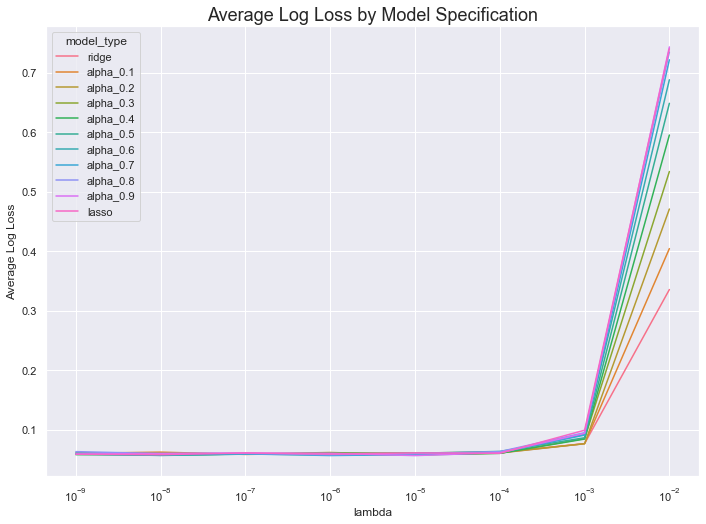

In [8]:
graph_log_loss(avg_loss_by_penalty, lambdas)

In [12]:
ridge_lambda, lasso_lambda, en_lambda, best_alpha = get_best_vals(avg_loss_by_penalty, lambdas)
print("Best lambda for ridge regularization: ", ridge_lambda)
print("Best lambda for lasso regularization: ", lasso_lambda)
print("Best lambda for elastic net regularization: ", en_lambda)
print("Best alpha for elastic net regularization: ", best_alpha)

Best lambda for ridge regularization:  1e-06
Best lambda for lasso regularization:  1e-08
Best lambda for elastic net regularization:  1e-08
Best alpha for elastic net regularization:  0.6000000000000001


In [13]:
# Train data predictions
train_pred_ridge = predict(X_train, y_train,  X_train, 0, ridge_lambda, 0.01, 100000)
train_pred_lasso = predict(X_train, y_train,  X_train, 1, lasso_lambda, 0.01, 100000)
train_pred_en = predict(X_train, y_train,  X_train, best_alpha, en_lambda, 0.01, 100000)

In [14]:
# Select threshold and calculate train accuracy
threshold = 0.5
train_accuracy_r = pred_to_accuracy(train_pred_ridge, y_train, threshold)
train_accuracy_l = pred_to_accuracy(train_pred_lasso, y_train, threshold)
train_accuracy_en = pred_to_accuracy(train_pred_en, y_train, threshold)
print(train_accuracy_r)
print(train_accuracy_l)
print(train_accuracy_en)

0.8261416461580531
0.8240087503418102
0.8261416461580531


In [15]:
# Test data predictions
pred_ridge = predict(X_train, y_train,  X_test, 0, ridge_lambda, 0.01, 100000)
pred_lasso = predict(X_train, y_train,  X_test, 1, lasso_lambda, 0.01, 100000)
pred_en = predict(X_train, y_train,  X_test, best_alpha, en_lambda, 0.01, 100000)

In [16]:
# Calculate test accuracy
accuracy_r = pred_to_accuracy(pred_ridge, y_test, threshold)
accuracy_l = pred_to_accuracy(pred_lasso, y_test, threshold)
accuracy_en = pred_to_accuracy(pred_en, y_test, threshold)
print(accuracy_r)
print(accuracy_l)
print(accuracy_en)

0.5586885245901639
0.5582513661202186
0.5602185792349728
